# Prevendo gastos em saúde com modelo de regressão linear<br>
(https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/linear-regression-health-costs-calculator)

Desafio encontrado no freecodecamp, com objetivo principal de usar modelo de regressão linear para prever gastos em saúde. Foram feitas análises exploratorias e um esboço de analise preditiva com modelos de regressão linear. Como curiosidade e para fins de também foram implementados outros modelos de preditivos e investigação mais aprofundada de variáveis.

- Objetivo: utilizar modelo de regressão linear para prever de gastos em dolares em saúde da amostra

- Erro médio absoluto (média dos erros entre valores preditos e valores reais) deve ser menor ou igual a 3500

Qualquer sugestões e criticas construtivas são muito bem vindas.

# 1.Importando bibliotecas

In [1]:
# Análise e visualização de dados
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

# Pré-processamento
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

# Modelos e métricas
import shap
from sklearn import metrics
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, SGDRegressor

# Otimização de modelo
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel 
from sklearn.feature_selection import f_regression, mutual_info_regression

# Rede neural
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam

# Estilo de gráficos
plt.style.use('ggplot')

# Formatar saidas de tabelas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 2.Importando dataset e informações gerais

In [2]:
df = pd.read_csv('data/gastos_saude.csv')

# 4.Pré-processamento

## Train test split

In [3]:
X = df[['bmi', 'age', 'smoker']]
Y = df['expenses']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

## Transformações e encodings

In [4]:
numericas = x_train.select_dtypes('number').columns
categoricas = x_train.select_dtypes('object').columns

In [5]:
processador_num_1 = Pipeline([('s_scaler', StandardScaler())])

processador_cat_1 = Pipeline([('ohe', OneHotEncoder(drop = "if_binary"))])

preprocessador_1 = ColumnTransformer(transformers = [
    ("processador_num_1", processador_num_1, numericas),
    ("processador_cat_1", processador_cat_1, categoricas),
    ], remainder = 'passthrough', verbose_feature_names_out=False)

In [6]:
x_train_preproc = pd.DataFrame(preprocessador_1.fit_transform(x_train),
                               columns = preprocessador_1.get_feature_names_out())

x_test_preproc = pd.DataFrame(preprocessador_1.transform(x_test),
                               columns = preprocessador_1.get_feature_names_out())

# 5.Modelagem

## Ridge

Com Ridge Regression o objetivo é minimizar o erro quadrático somado a uma penalização da soma dos coeficientes ao quadrado. Isso ajuda a evitar overfitting e reduzir a influência de coeficientes menos relevantes.

In [7]:
ridge0 = RidgeCV(cv = 5, alphas = [0.001, 0.01, 0.1, 1, 10, 100])
ridge0.fit(x_train_preproc, y_train)
y_pred_ridge0 = ridge0.predict(x_test_preproc)

In [8]:
ridge0_intercept = ridge0.intercept_.round(3)
ridge0_score = ridge0.score(x_train_preproc, y_train).round(3)
ridge0_mse = metrics.mean_squared_error(y_test, y_pred_ridge0).round(3)
ridge0_mae = metrics.mean_absolute_error(y_test, y_pred_ridge0).round(3)

print("="*46)
print("Ridge Regression")
print("="*46)
print(f'Intercepto: {ridge0_intercept}')
print("-"*46)
print('Coeficientes')
for col_name, coef in zip(x_train_preproc.columns, ridge0.coef_):
    print(col_name,'=', round(coef, 3))
print("-"*46)
print(f'R²: {ridge0_score}')
print("-"*46)
print(f'Erro quadrático médio: {ridge0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {ridge0_mae}')
print("="*46)

Ridge Regression
Intercepto: 8432.144
----------------------------------------------
Coeficientes
bmi = 1978.61
age = 3751.058
smoker_yes = 23579.784
----------------------------------------------
R²: 0.743
----------------------------------------------
Erro quadrático médio: 35835719.158
----------------------------------------------
Erro absoluto médio: 4261.154


Ainda temos um MAE acima do limite proposto.

## Lasso

Com Lasso Regression o objetivo é minimizar o erro quadrático somado a uma penalização da soma dos valores absolutos dos coeficientes. Isso ajuda a evitar overfitting e a selecionar automaticamente as variáveis mais relevantes.

In [9]:
lasso0 = LassoCV()
lasso0.fit(x_train_preproc, y_train)
y_pred_lasso0 = lasso0.predict(x_test_preproc)

In [10]:
lasso0_intercept = lasso0.intercept_.round(3)
lasso0_score = lasso0.score(x_train_preproc, y_train).round(3)
lasso0_mse = metrics.mean_squared_error(y_test, y_pred_lasso0).round(3)
lasso0_mae = metrics.mean_absolute_error(y_test, y_pred_lasso0).round(3)

print("="*46)
print("Lasso Regression")
print("="*46)
print(f'Intercepto: {lasso0_intercept}')
print("-"*46)
print('Coeficientes')
for col_name, coef in zip(x_train_preproc.columns, lasso0.coef_):
    print(col_name,'=', round(coef, 3))
print("-"*46)
print(f'R²: {lasso0_score}')
print("-"*46)
print(f'Erro quadrático médio: {lasso0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {lasso0_mae}')
print("="*46)

Lasso Regression
Intercepto: 8403.632
----------------------------------------------
Coeficientes
bmi = 1977.38
age = 3754.329
smoker_yes = 23715.672
----------------------------------------------
R²: 0.743
----------------------------------------------
Erro quadrático médio: 35821057.118
----------------------------------------------
Erro absoluto médio: 4250.041


Continuamos com MAE acima do aceitável.

## Elastic Net

Com Elastic Net combinamos a penalização de Ridge e Lasso em uma única regressão, com um parâmetro de mistura que controla o grau de ambas as penalizações. Isso ajuda a lidar com problemas em que há multicolinearidade e muitas variáveis irrelevantes.

In [11]:
enet0 = ElasticNetCV()
enet0.fit(x_train_preproc, y_train)
y_pred_enet0 = enet0.predict(x_test_preproc)

In [12]:
enet0_intercept = enet0.intercept_.round(3)
enet0_score = enet0.score(x_train_preproc, y_train).round(3)
enet0_mse = metrics.mean_squared_error(y_test, y_pred_enet0).round(3)
enet0_mae = metrics.mean_absolute_error(y_test, y_pred_enet0).round(3)

print("="*46)
print("Elastic Net")
print("="*46)
print(f'Intercepto: {enet0_intercept}')
print("-"*46)
print('Coeficientes')
for col_name, coef in zip(x_train_preproc.columns, enet0.coef_):
    print(col_name,'=', round(coef, 3))
print("-"*46)
print(f'R²: {enet0_score}')
print("-"*46)
print(f'Erro quadrático médio: {enet0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {enet0_mae}')
print("="*46)

Elastic Net
Intercepto: 13177.839
----------------------------------------------
Coeficientes
bmi = 449.919
age = 712.044
smoker_yes = 962.007
----------------------------------------------
R²: 0.092
----------------------------------------------
Erro quadrático médio: 132283181.902
----------------------------------------------
Erro absoluto médio: 8846.293


Como resultado temos um MAE muito acima do aceitável. Devemos talvez investigar otimização de hiperparametros dos 3 modelos anteriores.

## Gradiente Descendente

Com gradiente descendente queremos minimizar a função de perda (como o erro quadrático) usando o método de gradiente descendente, que ajusta os coeficientes iterativamente para minimizar a função de perda. A versão estocástica usa amostras aleatórias do conjunto de treinamento para atualizar os coeficientes, o que torna o processo mais rápido e escalável para conjuntos de dados grandes.

In [13]:
sgdr0 = SGDRegressor()
sgdr0.fit(x_train_preproc, y_train)
y_pred_sgdr0 = sgdr0.predict(x_test_preproc)

In [14]:
sgdr0_intercept = sgdr0.intercept_.round(3)
sgdr0_score = sgdr0.score(x_train_preproc, y_train).round(3)
sgdr0_mse = metrics.mean_squared_error(y_test, y_pred_sgdr0).round(3)
sgdr0_mae = metrics.mean_absolute_error(y_test, y_pred_sgdr0).round(3)

print("="*46)
print("Gradiente Descendente")
print("="*46)
print(f'Intercepto: {sgdr0_intercept}')
print("-"*46)
print('Coeficientes')
for col_name, coef in zip(x_train_preproc.columns, sgdr0.coef_):
    print(col_name,'=', round(coef, 3))
print("-"*46)
print(f'R²: {sgdr0_score}')
print("-"*46)
print(f'Erro quadrático médio: {sgdr0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {sgdr0_mae}')
print("="*46)

Gradiente Descendente
Intercepto: [8404.412]
----------------------------------------------
Coeficientes
bmi = 1984.465
age = 3783.987
smoker_yes = 23673.074
----------------------------------------------
R²: 0.743
----------------------------------------------
Erro quadrático médio: 35841230.435
----------------------------------------------
Erro absoluto médio: 4255.338


Temos um modelo que performa discretamente melhor do que os anteriores, mas ainda acima do aceitável.

## Decision Tree Regressor

Usando Decision Tree Regressor dividimos recursivamente os dados em subconjuntos com base em variáveis e valores de corte que maximizam a pureza dos subconjuntos em relação à variável de destino. Isso cria uma estrutura de árvore de decisão que pode ser usada para prever a variável de destino para novos dados.

In [15]:
treeregr0 = DecisionTreeRegressor(max_depth=3)
treeregr0.fit(x_train_preproc, y_train)
y_pred_treeregr0 = treeregr0.predict(x_test_preproc)

In [16]:
# treeregr0_intercept = treeregr0.intercept_.round(3)
treeregr0_score = treeregr0.score(x_train_preproc, y_train).round(3)
treeregr0_mse = metrics.mean_squared_error(y_test, y_pred_treeregr0).round(3)
treeregr0_mae = metrics.mean_absolute_error(y_test, y_pred_treeregr0).round(3)

print("="*46)
print("Decision Tree Regressor")
print("="*46)
print(f'R²: {treeregr0_score}')
print("-"*46)
print(f'Erro quadrático médio: {treeregr0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {treeregr0_mae}')
print("="*46)

Decision Tree Regressor
R²: 0.859
----------------------------------------------
Erro quadrático médio: 24288654.491
----------------------------------------------
Erro absoluto médio: 2933.291


Sendo um modelo mais complexo já podemos observar MAE abaixo do limite estabelecido.

## Random Forest Regressor

Nesse caso criamos um conjunto de árvores de decisão usando amostras aleatórias do conjunto de treinamento e variáveis aleatórias para dividir os nós da árvore. Isso ajuda a reduzir a variância e o overfitting em comparação com uma única árvore de decisão.

In [17]:
rndr0 = RandomForestRegressor(max_depth=3)
rndr0.fit(x_train_preproc, y_train)
y_pred_rndr0 = rndr0.predict(x_test_preproc)

In [18]:
# rndr0_intercept = rndr0.intercept_.round(3)
rndr0_score = rndr0.score(x_train_preproc, y_train).round(3)
rndr0_mse = metrics.mean_squared_error(y_test, y_pred_rndr0).round(3)
rndr0_mae = metrics.mean_absolute_error(y_test, y_pred_rndr0).round(3)

print("="*46)
print("Random Forest Regressor")
print("="*46)
print(f'R²: {rndr0_score}')
print("-"*46)
print(f'Erro quadrático médio: {rndr0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {rndr0_mae}')
print("="*46)

Random Forest Regressor
R²: 0.864
----------------------------------------------
Erro quadrático médio: 21933394.938
----------------------------------------------
Erro absoluto médio: 2765.858


Com random forest também observamos resultados melhores.

## Gradient Boosting Regressor

Nesse modelo é criado conjunto de árvores de decisão que sejam ajustadas iterativamente aos resíduos da árvore anterior, minimizando a função de perda (como o erro quadrático). Isso ajuda a melhorar a precisão da previsão e a reduzir o overfitting.

In [19]:
gbr0 = GradientBoostingRegressor()
gbr0.fit(x_train_preproc, y_train)
y_pred_gbr0 = gbr0.predict(x_test_preproc)

In [20]:
# gbr0_intercept = gbr0.intercept_.round(3)
gbr0_score = gbr0.score(x_train_preproc, y_train).round(3)
gbr0_mse = metrics.mean_squared_error(y_test, y_pred_gbr0).round(3)
gbr0_mae = metrics.mean_absolute_error(y_test, y_pred_gbr0).round(3)

print("="*46)
print("Gradient Boost Regressor")
print("="*46)
print(f'R²: {gbr0_score}')
print("-"*46)
print(f'Erro quadrático médio: {gbr0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {gbr0_mae}')
print("="*46)

Gradient Boost Regressor
R²: 0.895
----------------------------------------------
Erro quadrático médio: 21984855.899
----------------------------------------------
Erro absoluto médio: 2648.382


Temos até agora o melhor modelo.

## Multilayer Perceptron (MLP) - SKLEARN

Aqui estamos lidando com um modelo estremamente poderoso, baseado em redes neurais, no qual o objetivo é criar uma rede neural artificial com várias camadas de neurônios interconectados, com o objetivo de prever uma variável de destino. Cada camada usa uma função de ativação para transformar a entrada em uma saída e a saída é propagada para a próxima camada. O MLP usa backpropagation para ajustar os pesos da rede para minimizar a função de perda (como o erro quadrático).

In [21]:
mlp0 = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp0.fit(x_train_preproc, y_train)
y_pred_mlp0 = mlp0.predict(x_test_preproc)

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.


In [22]:
# mlp0_intercept = mlp0.intercept_.round(3)
mlp0_score = mlp0.score(x_train_preproc, y_train).round(3)
mlp0_mse = metrics.mean_squared_error(y_test, y_pred_mlp0).round(3)
mlp0_mae = metrics.mean_absolute_error(y_test, y_pred_mlp0).round(3)

print("="*46)
print("Multilayer Perceptron - SKLEARN")
print("="*46)
print(f'R²: {mlp0_score}')
print("-"*46)
print(f'Erro quadrático médio: {mlp0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {mlp0_mae}')
print("="*46)

Multilayer Perceptron - SKLEARN
R²: 0.794
----------------------------------------------
Erro quadrático médio: 28546671.804
----------------------------------------------
Erro absoluto médio: 3525.067


Mesmo um modelo básico sem muitos ajustes ja nos da um resultado dentro dos limites estipulados.

## Radial Basis Function (RBF)

Temos aqui outro modelo utilizando redes neurais no qual o objetivo é criar uma rede neural artificial que usa funções de base radial para transformar as entradas em uma saída. As funções de base radial são centradas em pontos específicos no espaço de entrada e usam a distância Euclidiana entre os pontos de entrada e o centro para determinar a saída da função. A rede usa backpropagation para ajustar os pesos da rede para minimizar a função de perda (como o erro quadrático).

In [23]:
rbf0 = KernelRidge(kernel='rbf')
rbf0.fit(x_train_preproc, y_train)
y_pred_rbf0 = rbf0.predict(x_test_preproc)

In [24]:
# rbf0_intercept = rbf0.intercept_.round(3)
rbf0_score = rbf0.score(x_train_preproc, y_train).round(3)
rbf0_mse = metrics.mean_squared_error(y_test, y_pred_rbf0).round(3)
rbf0_mae = metrics.mean_absolute_error(y_test, y_pred_rbf0).round(3)

print("="*46)
print("Radial Basis Function")
print("="*46)
print(f'R²: {rbf0_score}')
print("-"*46)
print(f'Erro quadrático médio: {rbf0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {rbf0_mae}')
print("="*46)

Radial Basis Function
R²: 0.844
----------------------------------------------
Erro quadrático médio: 25871893.895
----------------------------------------------
Erro absoluto médio: 2930.043


Também temos um resultado adequado mesmo com um modelo sem ajuste de hiperparametros.

## Rede neural (Keras/Tensorflow)

In [60]:
X = df.drop(columns = ['expenses'])
Y = df['expenses']

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.3,
                                                    random_state=42)

In [61]:
num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes(exclude = 'number').columns

In [62]:
preprocessamento_numericas = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('escala_features',StandardScaler())
])
preprocessamento_categoricas = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(drop='if_binary'))
])

In [63]:
preprocessador_final = ColumnTransformer(transformers=[
    ('processamento_numericas',preprocessamento_numericas,num_cols),
    ('processamento_categoricas',preprocessamento_categoricas,cat_cols),
],remainder='passthrough',verbose_feature_names_out=False)

dados_treino_prep = pd.DataFrame(preprocessador_final.fit_transform(X_train),
                                 columns=preprocessador_final.get_feature_names_out())

dados_teste_prep = pd.DataFrame(preprocessador_final.fit_transform(X_test),
                                columns=preprocessador_final.get_feature_names_out())

In [64]:
train_samples = np.array(dados_treino_prep).astype('float32')
train_labels = np.array(y_train).astype('float32')

test_samples = np.array(dados_teste_prep).astype('float32')
test_labels = np.array(y_test).astype('float32')

In [65]:
model = Sequential([
    Dense(units = 16, input_shape = (9,), activation = 'relu'),
    Dense(units = 32, activation = 'relu'),
    Dense(units = 1, activation = 'linear')
])

In [66]:
model.compile(optimizer = Adam(learning_rate=0.05), loss = 'mean_squared_error', metrics = ['mae'])

In [67]:
model.fit(x = train_samples, y = train_labels, batch_size=10, validation_split=0.1, 
          epochs = 50, shuffle = True, verbose = True)

Epoch 1/50


85/85 [==============================] - 2s 4ms/step - loss: 176461504.0000 - mae: 9513.6064 - val_loss: 62032264.0000 - val_mae: 6074.8237
Epoch 2/50
85/85 [==============================] - 0s 3ms/step - loss: 46917408.0000 - mae: 5088.2065 - val_loss: 35457888.0000 - val_mae: 4094.1699
Epoch 3/50
85/85 [==============================] - 0s 3ms/step - loss: 38814724.0000 - mae: 4278.6631 - val_loss: 34354200.0000 - val_mae: 4086.7280
Epoch 4/50
85/85 [==============================] - 0s 2ms/step - loss: 37306892.0000 - mae: 4167.8628 - val_loss: 34308648.0000 - val_mae: 3909.4087
Epoch 5/50
85/85 [==============================] - 0s 3ms/step - loss: 37703820.0000 - mae: 4158.4580 - val_loss: 35095596.0000 - val_mae: 3548.0659
Epoch 6/50
85/85 [==============================] - 0s 3ms/step - loss: 34523752.0000 - mae: 3906.3123 - val_loss: 30940618.0000 - val_mae: 3538.5911
Epoch 7/50
85/85 [==============================] - 0s 2ms/step - loss: 32348690.0000 - mae: 3716.2930 - val_l

In [68]:
predictions = model.predict(x = test_samples, batch_size=10, verbose = 0)

In [69]:
mse, mae = model.evaluate(x=test_samples, y=test_labels)

 1/13 [=>............................] - ETA: 0s - loss: 10948852.0000 - mae: 2334.3726

13/13 [==============================] - 0s 2ms/step - loss: 20556272.0000 - mae: 2615.2454


In [70]:
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 20556272.0
MAE: 2615.245361328125


## Features influentes

### SHapley Additive exPlanations (SHAP) 

Os recursos anteriores estão disponíveis para os modelos mais "expliáveis", aqueles que são mais facilmente interpretáveis.<br>
Porém temos modelos chamados de caixa preta, no qual não conseguimos explicar de maneira clara as decisões que o modelo tomou para chegar ao resultado, como XGBoost, redes neurais, random forest, etc.<br>
Porém temos alguns recursos como LIME (Local Interpretable Model-Agnostic Explanations) e SHAP (SHapley Additive exPlanations), este ultimo baseado em teoria dos jogos. O objetivo do SHAP atribuir uma contribuição relativa a cada variável de entrada para a saída do modelo, de modo que seja possível entender como as decisões do modelo foram tomadas.
Nesse caso a técnica foi utilizada para fins de estudo.

In [71]:
# Criar um objeto "explicador" usando os dados de treino
explainer = shap.Explainer(reglin0, x_train_preproc)

# Computar valores SHAP para dados de teste
shap_values = explainer(x_test_preproc)

# Plotar predição para o modelo
shap.summary_plot(shap_values, x_test_preproc, title = "Importancia das features para o modelo - SHAP")


NameError: name 'reglin0' is not defined

Podemos observar pelo gráfico que o maior impacto do modelo estão, novamente, nas variáveis:
- tabagismo
- idade
- IMC

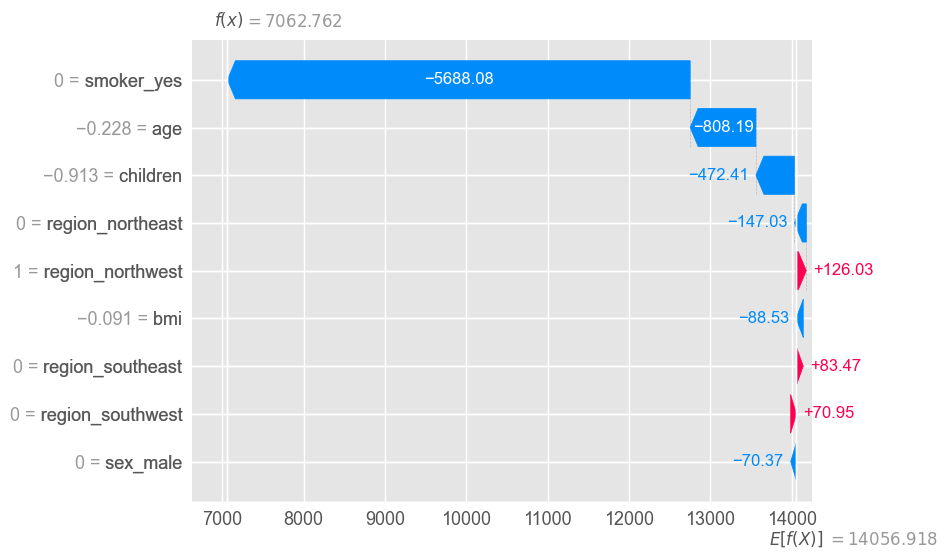

In [ ]:
# Plotar valores SHAP para uma predição
shap.plots.waterfall(shap_values[1])

## Otimizando modelo

Nosso modelo pode ser melhorado tanto pela retirada de features que, causam ruído e limitam a performance do modelo, quanto otimizando hiperparametros do modelo utilizado.<br>
<br>

# 6.Conclusão

Com uma função polinomial de grau III conseguimos implementar um modelo relativamente simples para resolver o problema. Observamos também que isso é possivel com modelos mais elaborados e robustos, porrém devemos ter cuidado pois alguns modelos podem tender mais facilmente ao overfitting e são computacionalmente mais caros.
Então se tivermos um modelo simples que atenda as nossas expectativas e resolva nosso problema de forma satisfatória sem sombra de duúvidas podemos utiliza-lo ganhando também em explicabilidade e agilidade.

# Referências

- https://towardsdatascience.com/shap-explain-any-machine-learning-model-in-python-72f0bea35f7c

- https://betterdatascience.com/shap/

- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

- https://github.com/smazzanti/mrmr

- https://machinelearningmastery.com/data-preparation-without-data-leakage/

- https://towardsdatascience.com/implement-gradient-descent-in-python-9b93ed7108d1

- https://betterdatascience.com/shap/